In [14]:
import os
import cv2
import time
import numpy as np
import ffmpeg
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision.transforms import ToPILImage

In [2]:
if os.name == 'nt':
    repo_path = Path(".").absolute().parent
    data_path = Path("D:/Datas/") / "lanevideo"
else:    
    repo_path = Path(".").absolute().parent
    data_path = repo_path.parent / "data" / "lanevideo"

In [7]:
def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([190, 190,   0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

def check_rotation(path_video_file):
    # this returns meta-data of the video file in form of a dictionary
    meta_dict = ffmpeg.probe(path_video_file)

    # from the dictionary, meta_dict['streams'][0]['tags']['rotate'] is the key
    # we are looking for
    rotate_code = None
    if int(meta_dict['streams'][0]['tags']['rotate']) == 90:
        rotate_code = cv2.ROTATE_90_CLOCKWISE
    elif int(meta_dict['streams'][0]['tags']['rotate']) == 180:
        rotate_code = cv2.ROTATE_180
    elif int(meta_dict['streams'][0]['tags']['rotate']) == 270:
        rotate_code = cv2.ROTATE_90_COUNTERCLOCKWISE

    return rotate_code

def correct_rotation(frame, rotate_code):
     return cv2.rotate(frame, rotate_code) 

In [45]:
video_path = str(data_path / "v2.mp4")
cap = cv2.VideoCapture(video_path)
rotate_code = check_rotation(video_path)
while(cap.isOpened()):
    ret, frame = cap.read()

    if ret:
        frame = correct_rotation(frame, rotate_code)
        masked = select_rgb_white_yellow(frame)
        images = np.hstack([frame, masked])
        cv2.imshow("video", images)
        key = cv2.waitKey(1)
        if key == 27:
            break
    else:
        break
    #cv2.imshow('frame', ti[0])
if not ret:
    cv2.destroyAllWindows()

In [52]:
cv2.destroyAllWindows()

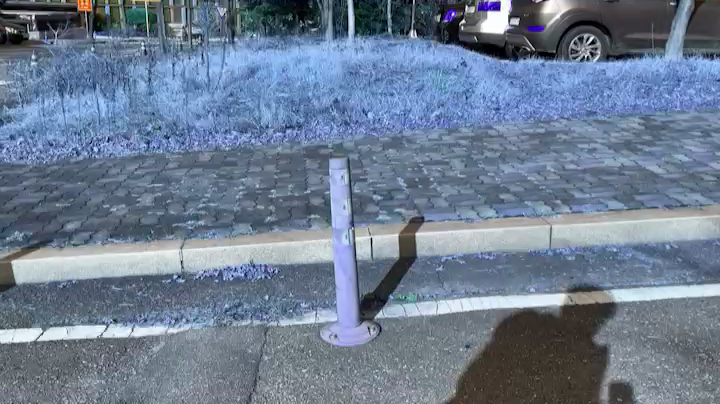

In [60]:
ToPILImage()(frame)

In [51]:
cv2.imshow("a", frame)